### Import statements

In [ ]:
from netCDF4 import Dataset
import numpy as np
import glob
import os
from wrf import getvar
from pint import UnitRegistry
import wrf
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
import scipy
import xarray as xr
import pandas as pd

### Extract Skew-T variables for singular time steps and average them over the metropolitan area

In [3]:
units = UnitRegistry()
runs = [1,2,3,4,5]

# Select storm by year
year = '2024'
names = [f'Cropland_{year}',f'Natland_{year}',f'BEPBEM_GrUrban_{year}',f'BEPBEM_WRFDef_{year}',f'NoUCM_WRFDef_{year}',f'NoUCM_GrUrban_{year}']

# For each ensemble member and setup for the selected storm case extract Skew-T variables
for name in names:
    for run in runs:

        # Find the files for each dataset
        if run == 1:
            DIREC = name
            DIR_PATH = f"/g/data/li18/em3807_2/WRF_runs/{name}"
        else:
            DIREC = f"{name}_{run}"
            DIR_PATH = f"/g/data/li18/em3807_2/WRF_runs/{name}_{run}"

        # Define the specific timesteps to extract
        date = '13'

        # DESIRED_TIMES = [
        #     "2017-02-17_22:00:00",
        #     "2017-02-18_01:00:00",
        #     "2017-02-18_04:00:00",
        #     "2017-02-18_07:00:00"
        # ]

        # DESIRED_TIMES = [
        #     "2018-12-19_22:00:00",
        #     "2018-12-20_01:00:00",
        #     "2018-12-20_04:00:00",
        #     "2018-12-20_07:00:00"
        # ]

        # DESIRED_TIMES = [
        #     "2020-12-16_22:00:00",
        #     "2020-12-17_01:00:00",
        #     "2020-12-17_04:00:00",
        #     "2020-12-17_07:00:00"
        # ]

        DESIRED_TIMES = [
            "2024-02-12_22:00:00",
            "2024-02-13_01:00:00",
            "2024-02-13_04:00:00",
            "2024-02-13_07:00:00"
        ]

        # Defining the metropolitan area using the gridded dataset
        data_gridded = [Dataset('/g/data/li18/em3807_2/WRF_runs/BEPBEM_GrUrban_2024/wrfout_d02_2024-02-11_00:00:00')]  
        land = wrf.getvar(data_gridded, 'LU_INDEX', timeidx=0, method='cat')
        urb = np.where(land <= 49, 0, land)
        urb[0:140, 0:200] = 0 # area below Sydney
        urb[0:289, 0:150] = 0 # left of Sydney
        urb[205:289, 0:279] = 0 # left of Sydney

        # Load in each file as a dataset
        if __name__ == "__main__":
            print(f"Looking for files in directory: {DIR_PATH}")

            # Find only domain 2 files for datasets
            file_list = sorted(glob.glob(os.path.join(DIR_PATH, "wrfout_d02*")))
            if not file_list:
                print("Error: No 'wrfout_d02*' files found. Exiting.")
                exit()

            # Make a list to store Skew-T variables
            all_times = []
            all_p = []
            all_T = []
            all_Td = []
            all_u = []
            all_v = []
            n_levels = 0

            # Process WRF files
            for file_path in file_list:
                try:
                    with Dataset(file_path, "r") as ds:
                        file_times = ds.variables['Times'][:]
                        file_times_str = np.array([''.join(c.astype(str)) for c in file_times])

                        # See if desired time is in the dataset
                        for desired_time_str in DESIRED_TIMES:
                            if desired_time_str in file_times_str:

                                # Find the index of the time in the dataset
                                time_idx = np.where(file_times_str == desired_time_str)[0][0]

                                # Extract the wanted variables
                                variables = [getvar(ds, "pressure", timeidx=time_idx), getvar(ds, "tc", timeidx=time_idx),
                                getvar(ds, "td", timeidx=time_idx), getvar(ds, "ua", timeidx=time_idx),
                                getvar(ds, "va", timeidx=time_idx)]
                                val_arr = []
                                for variable in variables:
                                    val_list = []

                                    # Find the mean of the variable across the Sydney metropolitan area
                                    for i in range(variables[0].shape[0]):
                                        ind_val = np.nanmean(np.where(urb == 0, np.nan, variable[i,:,:]))
                                        val_list.append(ind_val)
                                    val_arr.append(np.array(val_list))
                                p_profile = val_arr[0]
                                all_times.append(np.datetime64(desired_time_str.replace("_", "T")))
                                all_p.append(p_profile)
                                all_T.append(val_arr[1])
                                all_Td.append(val_arr[2])
                                all_u.append(val_arr[3])
                                all_v.append(val_arr[4])
                                
                                if n_levels == 0:
                                    n_levels = len(p_profile)
                except Exception as e:
                    print(f"Error processing file {os.path.basename(file_path)}: {e}")

            # Write to a netcdf file
            output_filename = os.path.join('/g/data/li18/em3807_2/WRF_runs/Skew-T', DIREC+"_"+date+"_urban_skewt.nc")
            if not all_p:
                print("No data was extracted. Exiting without creating a NetCDF file.")
                exit()
            
            with Dataset(output_filename, 'w', format='NETCDF4') as fout:
                fout.createDimension('time', None)  # Unlimited dimension
                fout.createDimension('level', n_levels)

                time_var = fout.createVariable('time', 'f8', ('time',))
                pressure_var = fout.createVariable('pressure', 'f4', ('time', 'level',))
                T_var = fout.createVariable('T', 'f4', ('time', 'level',))
                Td_var = fout.createVariable('Td', 'f4', ('time', 'level',))
                u_var = fout.createVariable('u', 'f4', ('time', 'level',))
                v_var = fout.createVariable('v', 'f4', ('time', 'level',))

                fout.description = "WRF point data extracted via Python script with netCDF4"
                fout.created_by = "Python Script with netCDF4 and wrf-python"

                # Add in units
                pressure_var.units = "hPa"
                T_var.units = "degC"
                Td_var.units = "degC"
                u_var.units = "m/s"
                v_var.units = "m/s"
                
                # Define a reference time so that the files can be opened in ncview 
                ref_time = np.datetime64('2020-12-16T00:00:00')
                seconds_since_ref = (np.array(all_times) - ref_time).astype('timedelta64[s]').astype(float)
                
                time_var.units = "seconds since 2017-02-18 00:00:00"
                time_var.long_name = "time of data"
                
                time_var[:] = seconds_since_ref
                pressure_var[:] = np.array(all_p)
                T_var[:] = np.array(all_T)
                Td_var[:] = np.array(all_Td)
                u_var[:] = np.array(all_u)
                v_var[:] = np.array(all_v)

            print(f"Done. Skew-T '{output_filename}' has been created.")

NameError: name 'UnitRegistry' is not defined

### Extracting skew-T data for averages prepreak

In [ ]:
ureg = UnitRegistry()

# Select storm date
date = '20'
runs = [1,2,3,4,5]
year = '2017'
setup = [f'Cropland_{year}', f'Natland_{year}', f'NoUCM_GrUrban_{year}', f'NoUCM_WRFDef_{year}', f'BEPBEM_GrUrban_{year}', f'BEPBEM_WRFDef_{year}']

# For each setup and ensemble member for the selected storm
for name in setup:
    for run in runs:
        if run == 1:
            DIREC = name
            DIR_PATH = f"/g/data/li18/em3807_2/WRF_runs/{name}"
        else:
            DIREC = f"{name}_{run}"
            DIR_PATH = f"/g/data/li18/em3807_2/WRF_runs/{name}_{run}"

        # Defining the metropolitan area in the gridded dataset
        data_gridded = [Dataset('/g/data/li18/em3807_2/WRF_runs/BEPBEM_GrUrban_2024/wrfout_d02_2024-02-11_00:00:00')]
        land = getvar(data_gridded, 'LU_INDEX', timeidx=0, method='cat')
        urb = np.where(land <= 49, 0, land)
        urb[0:140, 0:200] = 0  # area below Sydney
        urb[0:289, 0:150] = 0  # left of Sydney
        urb[205:289, 0:279] = 0  # left of Sydney

        # Process WRF files as datasets
        if __name__ == "__main__":
            print(f"Looking for files in directory: {DIR_PATH}")

            file_list = sorted(glob.glob(os.path.join(DIR_PATH, "wrfout_d02*")))
            if not file_list:
                print("Error: No domain 2 files found.")
                exit()
            
            # Define when the pre-storm and peak-storm hours start and end in UTC
            pre_storm_start = pd.to_datetime("2017-02-17 22:00:00")
            pre_storm_end   = pd.to_datetime("2017-02-17 23:00:00")
            peak_storm_start = pd.to_datetime("2017-02-18 09:00:00")
            peak_storm_end   = pd.to_datetime("2017-02-18 10:00:00")

            # pre_storm_start = pd.to_datetime("2018-12-20 00:30:00")
            # pre_storm_end   = pd.to_datetime("2018-12-20 01:30:00")
            # peak_storm_start = pd.to_datetime("2018-12-20 06:00:00")
            # peak_storm_end   = pd.to_datetime("2018-12-20 07:00:00")

            # pre_storm_start = pd.to_datetime("2020-12-16 19:00:00")
            # pre_storm_end   = pd.to_datetime("2020-12-16 20:00:00")
            # peak_storm_start = pd.to_datetime("2020-12-17 04:00:00")
            # peak_storm_end   = pd.to_datetime("2020-12-17 05:00:00")

            # pre_storm_start = pd.to_datetime("2024-02-12 23:00:00")
            # pre_storm_end   = pd.to_datetime("2024-02-13 00:00:00")
            # peak_storm_start = pd.to_datetime("2024-02-13 03:30:00")
            # peak_storm_end   = pd.to_datetime("2024-02-13 04:30:00")

            # Generate WRF time steps between the pre and peak ranges
            pre_storm_times = pd.date_range(pre_storm_start, pre_storm_end, freq="10min")
            peak_storm_times = pd.date_range(peak_storm_start, peak_storm_end, freq="10min")

            # Convert datetime to string
            def dt_to_str(dt):
                return dt.strftime("%Y-%m-%d_%H:%M:%S")

            pre_storm_times_str = [dt_to_str(dt) for dt in pre_storm_times]
            peak_storm_times_str = [dt_to_str(dt) for dt in peak_storm_times]

            pre_storm_data = {"times": [], "pressure": [], "T": [], "Td": [], "u": [], "v": []}
            peak_storm_data = {"times": [], "pressure": [], "T": [], "Td": [], "u": [], "v": []}
            n_levels = 0

            # Extract variables for the pre-storm and peak-storm hours
            for file_path in file_list:
                try:
                    with Dataset(file_path, "r") as ds:
                        file_times = ds.variables['Times'][:]
                        file_times_str = np.array([''.join(c.astype(str)) for c in file_times])

                        for desired_time_str in pre_storm_times_str + peak_storm_times_str:
                            if desired_time_str in file_times_str:
                                time_idx = np.where(file_times_str == desired_time_str)[0][0]

                                vars_to_get = [
                                    getvar(ds, "pressure", timeidx=time_idx),
                                    getvar(ds, "tc", timeidx=time_idx),
                                    getvar(ds, "td", timeidx=time_idx),
                                    getvar(ds, "ua", timeidx=time_idx),
                                    getvar(ds, "va", timeidx=time_idx),
                                ]
                                val_arr = []
                                for var in vars_to_get:
                                    profile = []

                                    # Average variables over the Sydney metropolitan
                                    for lev in range(var.shape[0]):
                                        arr2d = var[lev, :, :]
                                        masked = np.where(urb == 0, np.nan, arr2d)
                                        mean_val = np.nanmean(masked)
                                        profile.append(mean_val)
                                    val_arr.append(np.array(profile))

                                if desired_time_str in pre_storm_times_str:
                                    target = pre_storm_data
                                else:
                                    target = peak_storm_data

                                target["times"].append(np.datetime64(desired_time_str.replace("_", "T")))
                                target["pressure"].append(p_profile)
                                target["T"].append(val_arr[1])
                                target["Td"].append(val_arr[2])
                                target["u"].append(val_arr[3])
                                target["v"].append(val_arr[4])

                                if n_levels == 0:
                                    n_levels = len(p_profile)
                except Exception as e:
                    print(f"Error processing file {os.path.basename(file_path)}: {e}")

            all_times = np.array(pre_storm_data["times"] + peak_storm_data["times"])
            all_pressure = np.array(pre_storm_data["pressure"] + peak_storm_data["pressure"])
            all_T = np.array(pre_storm_data["T"] + peak_storm_data["T"])
            all_Td = np.array(pre_storm_data["Td"] + peak_storm_data["Td"])
            all_u = np.array(pre_storm_data["u"] + peak_storm_data["u"])
            all_v = np.array(pre_storm_data["v"] + peak_storm_data["v"])

            labels = ["pre"] * len(pre_storm_data["times"]) + ["peak"] * len(peak_storm_data["times"])

            # Write to a netcdf file
            output_filename = os.path.join('/g/data/li18/em3807_2/WRF_runs/Skew-T',
                                        f"{DIREC}_{date}_prepeak_skewt.nc")

            with Dataset(output_filename, 'w', format='NETCDF4') as fout:
                fout.createDimension('time', None)
                fout.createDimension('level', n_levels)

                time_var = fout.createVariable('time', 'f8', ('time',))
                pressure_var = fout.createVariable('pressure', 'f4', ('time', 'level'))
                T_var = fout.createVariable('T', 'f4', ('time', 'level'))
                Td_var = fout.createVariable('Td', 'f4', ('time', 'level'))
                u_var = fout.createVariable('u', 'f4', ('time', 'level'))
                v_var = fout.createVariable('v', 'f4', ('time', 'level'))
                label_var = fout.createVariable('stage', str, ('time',))  # label: pre or post

                fout.description = "WRF pre‑storm and peak‑storm point data"
                fout.created_by = "Python script with netCDF4 and wrf‑python"

                pressure_var.units = "hPa"
                T_var.units = "degC"
                Td_var.units = "degC"
                u_var.units = "m/s"
                v_var.units = "m/s"

                ref_time = all_times.min()
                seconds_since_ref = (all_times - ref_time).astype('timedelta64[s]').astype(float)

                time_var.units = f"seconds since {ref_time.astype('datetime64[s]')}"
                time_var.long_name = "time"

                time_var[:] = seconds_since_ref
                pressure_var[:, :] = all_pressure
                T_var[:, :]        = all_T
                Td_var[:, :]       = all_Td
                u_var[:, :]        = all_u
                v_var[:, :]        = all_v
                label_var[:] = np.array(labels, dtype=object)

            print(f"Done. File '{output_filename}' has been created.")


Starting WRF data processing...
Looking for files in directory: /g/data/li18/em3807_2/WRF_runs/Cropland_2017
Processing complete. New file '/g/data/li18/em3807_2/WRF_runs/Skew-T/Cropland_2017_17_ci_prepeak_skewt.nc' has been created.
Starting WRF data processing...
Looking for files in directory: /g/data/li18/em3807_2/WRF_runs/Cropland_2017_2
Processing complete. New file '/g/data/li18/em3807_2/WRF_runs/Skew-T/Cropland_2017_2_17_ci_prepeak_skewt.nc' has been created.
Starting WRF data processing...
Looking for files in directory: /g/data/li18/em3807_2/WRF_runs/Cropland_2017_3
Processing complete. New file '/g/data/li18/em3807_2/WRF_runs/Skew-T/Cropland_2017_3_17_ci_prepeak_skewt.nc' has been created.
Starting WRF data processing...
Looking for files in directory: /g/data/li18/em3807_2/WRF_runs/Cropland_2017_4
Processing complete. New file '/g/data/li18/em3807_2/WRF_runs/Skew-T/Cropland_2017_4_17_ci_prepeak_skewt.nc' has been created.
Starting WRF data processing...
Looking for files in

### Creating barchart data

In [ ]:
# Setup ensemble
mains = ['Cropland','Natland','NoUCM_GrUrban','BEPBEM_GrUrban','NoUCM_WRFDef','BEPBEM_WRFDef']
for name_main in mains:
    name_crop = 'Cropland'
    year = '2017'
    date = '18'
    print(name_main)

    # Defining files for the cropland and comparison setup
    ensemble_main_files = [
        f"/g/data/li18/em3807_2/WRF_runs/Skew-T/{name_main}_{year}_{date}_urban_prepeak_skewt.nc",
        f"/g/data/li18/em3807_2/WRF_runs/Skew-T/{name_main}_{year}_2_{date}_urban_prepeak_skewt.nc",
        f"/g/data/li18/em3807_2/WRF_runs/Skew-T/{name_main}_{year}_3_{date}_urban_prepeak_skewt.nc",
        f"/g/data/li18/em3807_2/WRF_runs/Skew-T/{name_main}_{year}_4_{date}_urban_prepeak_skewt.nc",
        f"/g/data/li18/em3807_2/WRF_runs/Skew-T/{name_main}_{year}_5_{date}_urban_prepeak_skewt.nc",
    ]

    ensemble_crop_files = [
        f"/g/data/li18/em3807_2/WRF_runs/Skew-T/{name_crop}_{year}_{date}_urban_prepeak_skewt.nc",
        f"/g/data/li18/em3807_2/WRF_runs/Skew-T/{name_crop}_{year}_2_{date}_urban_prepeak_skewt.nc",
        f"/g/data/li18/em3807_2/WRF_runs/Skew-T/{name_crop}_{year}_3_{date}_urban_prepeak_skewt.nc",
        f"/g/data/li18/em3807_2/WRF_runs/Skew-T/{name_crop}_{year}_4_{date}_urban_prepeak_skewt.nc",
        f"/g/data/li18/em3807_2/WRF_runs/Skew-T/{name_crop}_{year}_5_{date}_urban_prepeak_skewt.nc",
    ]

    ensemble_names = ["ens1","ens2","ens3","ens4","ens5"]
    metrics = ["cape", "cin", "bulk_shear", "surf_dewpoint", "ground_temp"]

    # Define functions for averaging and calculating storm variables
    def safe_mean(arr, mask):
        if np.any(mask):
            return np.nanmean(arr[mask])
        else:
            return np.nan

    def compute_metrics(ds):
        p_arr  = ds['pressure'].values * units.hPa
        T_arr  = ds['T'].values * units.degC
        Td_arr = ds['Td'].values * units.degC
        u_arr  = ds['u'].values * units('m/s')
        v_arr  = ds['v'].values * units('m/s')
        stage  = ds['stage'].values  # array of pre-storm and post-storm variables

        surf_dewpoint_arr = Td_arr[:,0].magnitude
        ground_temp_arr   = T_arr[:,0].magnitude
        ntime, nlevel = p_arr.shape

        cape_arr   = np.full(ntime, np.nan, dtype=float)
        cin_arr    = np.full(ntime, np.nan, dtype=float)
        shear_arr  = np.full(ntime, np.nan, dtype=float)
        u_bot_arr = np.full(ntime, np.nan, dtype=float)
        u_top_arr = np.full(ntime, np.nan, dtype=float)
        v_bot_arr = np.full(ntime, np.nan, dtype=float)
        v_top_arr = np.full(ntime, np.nan, dtype=float) 

        for ti in range(ntime):
            p_prof  = p_arr[ti, :]
            T_prof  = T_arr[ti, :]
            Td_prof = Td_arr[ti, :]
            u_prof  = u_arr[ti, :]
            v_prof  = v_arr[ti, :]

            if np.all(np.isnan(p_prof)) or np.all(np.isnan(T_prof)):
                continue

            # Mixed-layer CIN and CAPE
            try:
                ml_cape, ml_cin = mpcalc.mixed_layer_cape_cin(
                    p_prof, T_prof, Td_prof, depth=50 * units.hPa
                )
                cape_arr[ti] = ml_cape.to('J/kg').magnitude
                cin_arr[ti]  = ml_cin.to('J/kg').magnitude
            except Exception as e:
                print(f"   CAPE/CIN error at time {ti}: {e}")

            # Bulk shear
            try:
                ub, vb = mpcalc.bulk_shear(
                    p_prof, u_prof, v_prof,
                    depth=6000 * units.meters, bottom=p_prof[0]
                )
                shear_arr[ti] = mpcalc.wind_speed(ub, vb).to('m/s').magnitude
            except Exception as e:
                print(f"   Shear error at time {ti}: {e}")

        mask_pre  = (stage == "pre")
        mask_peak = (stage == "peak")

        out = {}

        # Averaging variables across pre-storm and peak-storm hours
        out['cape'] = {
            "pre": safe_mean(cape_arr, mask_pre),
            "peak": safe_mean(cape_arr, mask_peak)
        }
        out['cin'] = {
            "pre": safe_mean(cin_arr, mask_pre),
            "peak": safe_mean(cin_arr, mask_peak)
        }
        out['bulk_shear'] = {
            "pre": safe_mean(shear_arr, mask_pre),
            "peak": safe_mean(shear_arr, mask_peak)
        }

        out['surf_dewpoint'] = {
            "pre": np.nanmean(surf_dewpoint_arr[mask_pre]),
            "peak": np.nanmean(surf_dewpoint_arr[mask_peak])
        }
        out['ground_temp'] = {
            "pre": np.nanmean(ground_temp_arr[mask_pre]),
            "peak": np.nanmean(ground_temp_arr[mask_peak])
        }

        return out

    diff_abs = {m: {"pre": [], "peak": []} for m in metrics}
    diff_pct = {m: {"pre": [], "peak": []} for m in metrics}

    # Find the differences in these variables for all setups to the Cropland case
    for fname_main, fname_crop, ename in zip(ensemble_main_files, ensemble_crop_files, ensemble_names):
        print(f"Processing ensemble: {ename}")
        ds_main = xr.open_dataset(fname_main)
        ds_crop = xr.open_dataset(fname_crop)

        metrics_main = compute_metrics(ds_main)
        metrics_crop = compute_metrics(ds_crop)

        # Calculating percentage and absolute differences
        for m in metrics:
            for stage_label in ["pre", "peak"]:
                val_main = metrics_main[m][stage_label]
                val_crop = metrics_crop[m][stage_label]
                if m == 'bulk_shear' and stage_label == 'pre':
                    shrs.append(val_main)
                diff = val_main - val_crop
                diff_abs[m][stage_label].append(diff)

                if (val_crop is None) or np.isnan(val_crop) or val_crop == 0:
                    pct = np.nan
                else:
                    pct = 100.0 * diff / val_crop
                diff_pct[m][stage_label].append(pct)

    # Summarise storm variables in a dictionary
    summary_abs = {}
    summary_pct = {}
    for m in metrics:
        summary_abs[m] = {}
        summary_pct[m] = {}
        for stage_label in ["pre", "peak"]:
            arr_abs = np.array( diff_abs[m][stage_label] )
            arr_pct = np.array( diff_pct[m][stage_label] )

            summary_abs[m][stage_label] = {
                "min":   np.nanmin(arr_abs),
                "mean":  np.nanmean(arr_abs),
                "max":   np.nanmax(arr_abs),
                "all_members": arr_abs
            }
            summary_pct[m][stage_label] = {
                "min":   np.nanmin(arr_pct),
                "mean":  np.nanmean(arr_pct),
                "max":   np.nanmax(arr_pct),
                "all_members": arr_pct
            }

    # Save to netcdf file

    rows = []
    for m in metrics:
        for stage_label in ["pre", "peak"]:
            d_abs = summary_abs[m][stage_label]
            d_pct = summary_pct[m][stage_label]
            rows.append({
                "metric":       m,
                "stage":        stage_label,
                "abs_min":      d_abs["min"],
                "abs_mean":     d_abs["mean"],
                "abs_max":      d_abs["max"],
                "pct_min":      d_pct["min"],
                "pct_mean":     d_pct["mean"],
                "pct_max":      d_pct["max"],
            })
    # df = pd.DataFrame(rows)

    # ds_out = xr.Dataset.from_dataframe(df.set_index(["metric","stage"]))

    # out_nc = f"/home/561/em3807/honours-project/Average_bardata/{name_main}_vs_{name_crop}_{year}_peak.nc"
    # ds_out.to_netcdf(out_nc, mode='w', format='NETCDF4')
    # print(f"Written difference summary (with surface & ground) to {out_nc}")


### Plotting barchart data

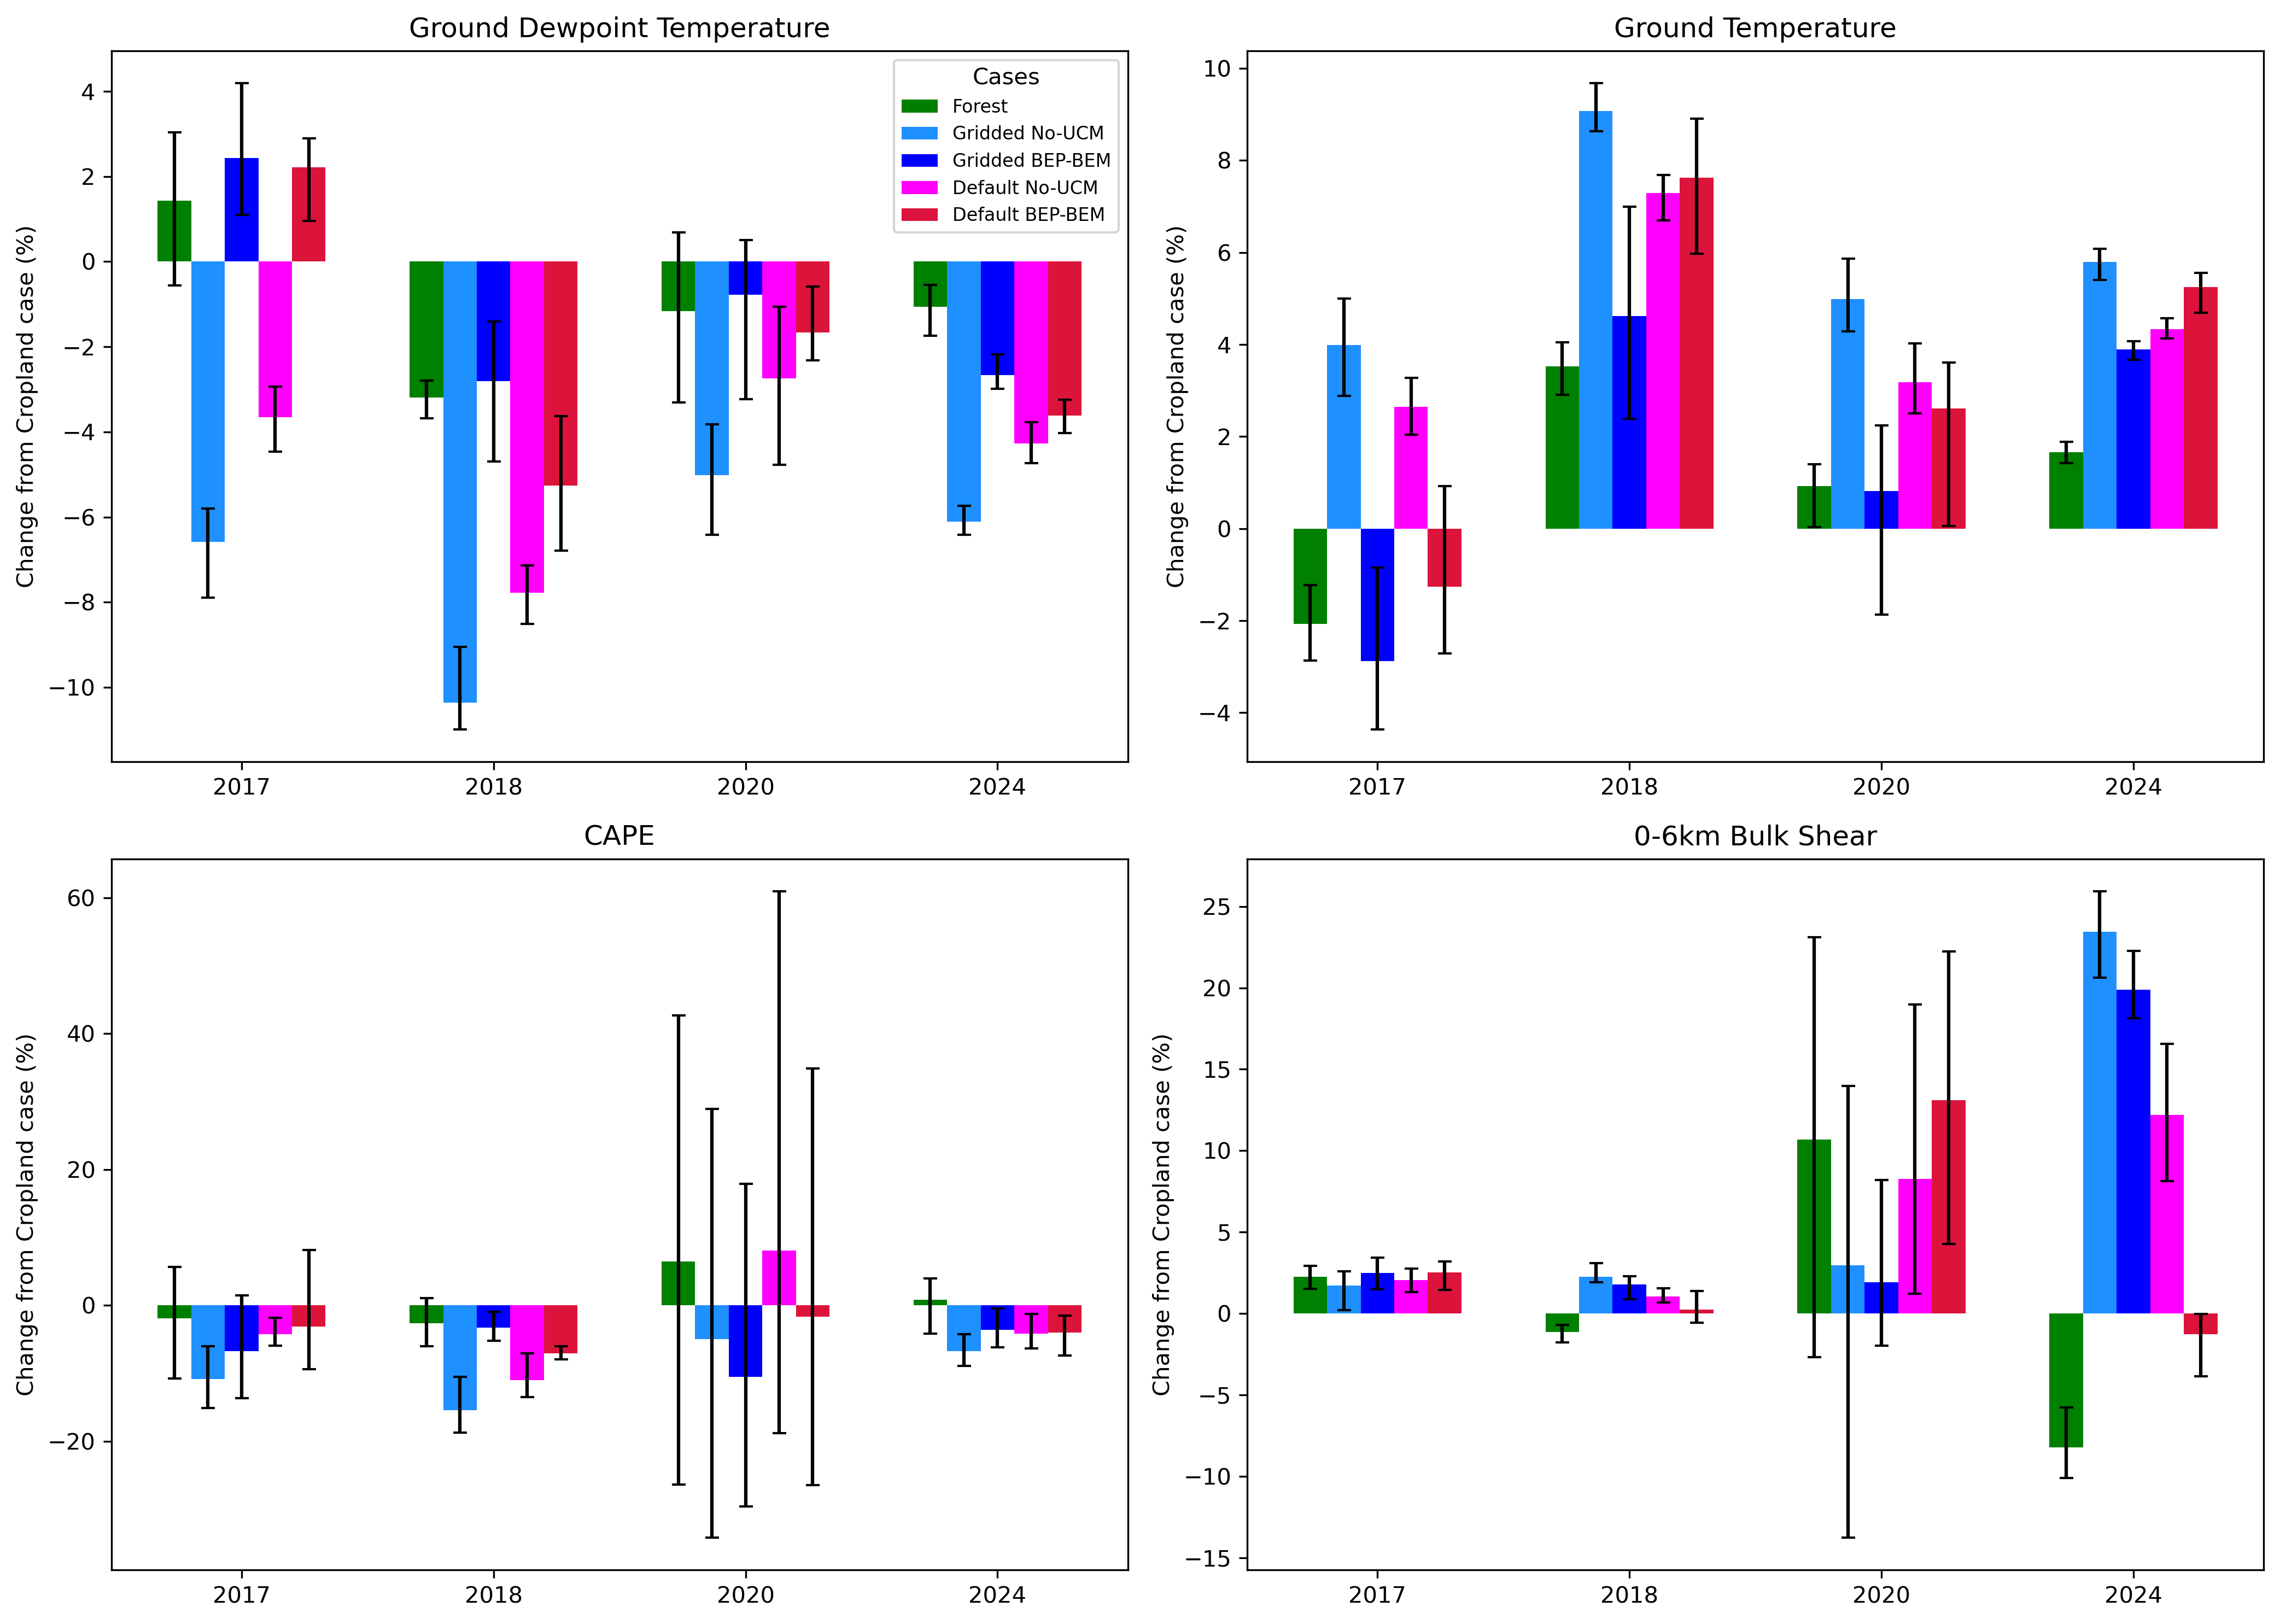

In [ ]:
# Matching names in dataset to plot names
plot_names = {
    'surf_dewpoint': 'Ground Dewpoint Temperature',
    'ground_temp': 'Ground Temperature',
    'cape': 'CAPE',
    'bulk_shear': '0-6km Bulk Shear'
}
variables = list(plot_names.keys())

# Define storm years and set up ensemble names and colours
years = [2017, 2018, 2020, 2024]
case_labels = ['Forest', 'Gridded No-UCM', 'Gridded BEP-BEM', 'Default No-UCM', 'Default BEP-BEM']
colours = ['green', 'dodgerblue', 'blue', 'magenta', 'crimson']

# Select variables for the pre-storm period of each case
stages = ['pre']

# Space bars horizontally for the plot
n_times = len(stages)
n_cases = len(case_labels)
bar_width = 0.12
year_gap = 0.3 

# Make figure
fig, axs = plt.subplots(2, 2, figsize=(14, 10), dpi=300)
axs = axs.flatten() 

# Plot Skew-T variables
for v_idx, variable in enumerate(variables):
    ax = axs[v_idx]
    p_name = plot_names[variable]
    
    xtick_positions = []
    xtick_labels = []

    for y_idx, year in enumerate(years):
        # Load datasets for the year
        defurb = xr.open_dataset(f'/home/561/em3807/honours-project/Average_bardata/BEPBEM_WRFDef_vs_Cropland_{year}_peak.nc')
        defn = xr.open_dataset(f'/home/561/em3807/honours-project/Average_bardata/NoUCM_WRFDef_vs_Cropland_{year}_peak.nc')
        gr = xr.open_dataset(f'/home/561/em3807/honours-project/Average_bardata/NoUCM_GrUrban_vs_Cropland_{year}_peak.nc')
        grurb = xr.open_dataset(f'/home/561/em3807/honours-project/Average_bardata/BEPBEM_GrUrban_vs_Cropland_{year}_peak.nc')
        nat = xr.open_dataset(f'/home/561/em3807/honours-project/Average_bardata/Natland_vs_Cropland_{year}_peak.nc')

        cases = [nat, gr, grurb, defn, defurb]
        x_base = y_idx * (n_cases * bar_width + year_gap)

        # Plot average percentage differences 
        for i, case in enumerate(cases):
            avgval = []
            low = []
            high = []
            for t in stages:
                avgval.append(case['pct_mean'].sel(metric=variable, stage=t).item())
                low.append(case['pct_min'].sel(metric=variable, stage=t).item())
                high.append(case['pct_max'].sel(metric=variable, stage=t).item())
            avgval = np.array(avgval)
            low = np.array(low)
            high = np.array(high)

            # Plot errorbars for percentage differences
            yerrmin = avgval - low
            yerrmax = high - avgval
            y_error = [yerrmin, yerrmax]

            bar_pos = x_base + i * bar_width
            ax.bar(bar_pos, avgval, yerr=y_error, capsize=3, width=bar_width,
                   label=case_labels[i] if y_idx == 0 else "",  # Label only once
                   color=colours[i])

        xtick_positions.append(x_base + (n_cases - 1) * bar_width / 2)
        xtick_labels.append(str(year))

    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels)
    ax.set_title(p_name)
    ax.set_ylabel('Change from Cropland case (%)')
    if v_idx == 0:
        ax.legend(title="Cases", fontsize=8)

plt.tight_layout()
plt.show()
